In [1]:
%matplotlib inline
# %matplotlib widget # for interactive

# Resonance excitation for slow extraction

In [2]:
import matplotlib.pyplot as plt
import xtrack as xt
import numpy as np

### Load the model

In [3]:
env = xt.load('./pimm_extr.json')
env.vars.load('./pimm_strengths.json')

line = env.ring
line.configure_bend_model(num_multipole_kicks=5)

tw = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/195 [00:00<?, ?it/s]

### Bring horizontal tune close to 3rd order resonance

In [4]:
opt = line.match(
    solve=False, # <- prepare the match without running it
    compute_chromatic_properties=False,
    method='4d',
    vary=[
        xt.Vary('kqfa', limits=(0, 10),  step=1e-3),
        xt.Vary('kqfb', limits=(0, 10),  step=1e-3),
        xt.Vary('kqd', limits=(-10, 0), step=1e-3),
    ],
    targets=[
        xt.TargetSet(qx=1.665, qy=1.72, tol=1e-4),
        xt.TargetSet(dx=0, at='mid.lss.0', tol=2e-3),
        xt.TargetSet(dx=0, at='mid.lss.1', tol=2e-3),
    ]
)
opt.step(20)
opt.target_status()

                                             
Optimize - start penalty: 0.2767                            
Matching: model call n. 11 penalty = 3.0961e-04              
Optimize - end penalty:  0.000309614                            
Target status:               nalty = 3.0961e-04              
id state tag          tol_met       residue   current_val    target_val description                                 
0  ON    qx              True   3.71426e-07         1.665         1.665 'qx', val=1.665, tol=0.0001, weight=10      
1  ON    qy              True   3.64865e-08          1.72          1.72 'qy', val=1.72, tol=0.0001, weight=10       
2  ON    mid.lss.0_dx    True    2.0854e-05    2.0854e-05             0 ('dx', 'mid.lss.0'), val=0, tol=0.002, w ...
3  ON    mid.lss.1_dx    True  -2.28819e-05  -2.28819e-05             0 ('dx', 'mid.lss.1'), val=0, tol=0.002, w ...


### Use MAD-NG to see how extraction sextupole (mse) excites the thrid order resonance

In [5]:
# Compute Resonant Drivint Term (RDT)
env['kse'] = 0.
tw_ng_mse_0 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 1.
tw_ng_mse_1 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 2.
tw_ng_mse_2 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 3.
tw_ng_mse_3 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 4.
tw_ng_mse_4 = line.madng_twiss(rdts=['f3000'])

Building MAD-NG model for line None with sequence name seq


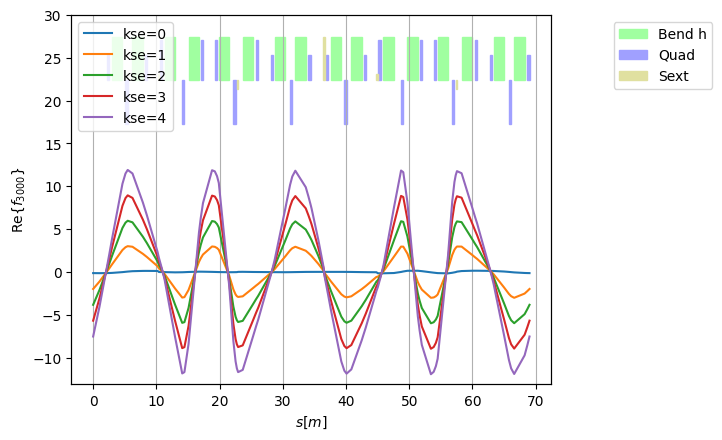

In [6]:
# Plot RDT vs mse strength
pl = tw_ng_mse_4.plot(lattice_only=True)
ax = pl.left

ax.plot(tw_ng_mse_0.s, np.real(tw_ng_mse_0.f3000), label='kse=0')
ax.plot(tw_ng_mse_1.s, np.real(tw_ng_mse_1.f3000), label='kse=1')
ax.plot(tw_ng_mse_2.s, np.real(tw_ng_mse_2.f3000), label='kse=2')
ax.plot(tw_ng_mse_3.s, np.real(tw_ng_mse_3.f3000), label='kse=3')
ax.plot(tw_ng_mse_4.s, np.real(tw_ng_mse_4.f3000), label='kse=4')

pl.ylim(left_hi=30, right_lo=-20, right_hi=20,
        lattice_hi=1.5, lattice_lo=-7)
ax.set_ylabel(r'Re$\{f_{3000}\}$');
ax.legend(loc='upper left')

### Observe deformation of phase space when exciting the resonance

In [7]:
# Generate 20 particles on the x axis
x_gen = np.linspace(0, 0.5e-2, 20)
p0 = line.build_particles(x=x_gen, px=0, y=0, py=0, zeta=0, delta=0)

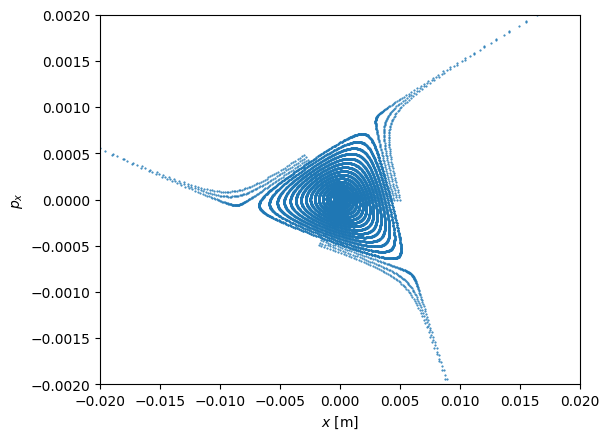

In [8]:
# Set extraction sextupole
env['kse'] = 5

# Track 1000 turns
line.track(p0.copy(), num_turns=1000, turn_by_turn_monitor=True)
rec = line.record_last_track

# Plot turn-by-turn data
plt.figure()
plt.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$p_x$'), plt.xlim(-2e-2, 2e-2); plt.ylim(-2e-3, 2e-3)
plt.subplots_adjust(left=.15)